In [2]:
from langchain.utilities import SQLDatabase
from langchain.llms import GooglePalm
from dotenv import load_dotenv
import os
load_dotenv()
api_key = os.environ['GOOGLE_API_KEY']
db_user = os.environ['DB_USER']
db_password = os.environ['DB_PASS']
db_host = os.environ['DB_HOST_NAME']
db_name = os.environ['DB_NAME']

#### Database Connectivity 

In [3]:
llm = GooglePalm(google_api_key=api_key,temperature=0.2)
llm('Write a poen on india')

e:\Github\LLM\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'India, my beloved land,\nYou are a land of contrasts,\nFrom the snow-capped Himalayas\nTo the lush green jungles of the south.\n\nYou are a land of cultures,\nFrom the ancient Vedic traditions\nTo the modern skyscrapers of Mumbai.\n\nYou are a land of people,\nFrom the diverse tribes of the north-east\nTo the cosmopolitan cities of the west.\n\nIndia, you are a land of beauty,\nFrom the majestic Taj Mahal\nTo the golden beaches of Goa.\n\nYou are a land of hope,\nFrom the struggles of the independence movement\nTo the achievements of the present day.\n\nIndia, you are my home,\nAnd I will always love you.'

In [4]:
db = SQLDatabase.from_uri(f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_name}",sample_rows_in_table_info=3)
print(db.table_info) ## sample_rows_in_table_info will print 3 rows 


CREATE TABLE discounts (
	discount_id INTEGER NOT NULL AUTO_INCREMENT, 
	t_shirt_id INTEGER NOT NULL, 
	pct_discount DECIMAL(5, 2), 
	PRIMARY KEY (discount_id), 
	CONSTRAINT discounts_ibfk_1 FOREIGN KEY(t_shirt_id) REFERENCES t_shirts (t_shirt_id), 
	CONSTRAINT discounts_chk_1 CHECK ((`pct_discount` between 0 and 100))
)COLLATE utf8mb4_0900_ai_ci ENGINE=InnoDB DEFAULT CHARSET=utf8mb4

/*
3 rows from discounts table:
discount_id	t_shirt_id	pct_discount
1	1	10.00
2	2	15.00
3	3	20.00
*/


CREATE TABLE t_shirts (
	t_shirt_id INTEGER NOT NULL AUTO_INCREMENT, 
	brand ENUM('Van Huesen','Levi','Nike','Adidas') NOT NULL, 
	color ENUM('Red','Blue','Black','White') NOT NULL, 
	size ENUM('XS','S','M','L','XL') NOT NULL, 
	price INTEGER, 
	stock_quantity INTEGER NOT NULL, 
	PRIMARY KEY (t_shirt_id), 
	CONSTRAINT t_shirts_chk_1 CHECK ((`price` between 10 and 50))
)COLLATE utf8mb4_0900_ai_ci ENGINE=InnoDB DEFAULT CHARSET=utf8mb4

/*
3 rows from t_shirts table:
t_shirt_id	brand	color	size	price	stock

### SQL Database Chain

In [5]:
from langchain_experimental.sql import SQLDatabaseChain
db_chain = SQLDatabaseChain.from_llm(llm, db, verbose=True)
qns1 = db_chain("How many t-shirts do we have left for nike in extra small size and white color?")




> Entering new SQLDatabaseChain chain...
How many t-shirts do we have left for nike in extra small size and white color?
SQLQuery:SELECT stock_quantity FROM t_shirts WHERE brand = 'Nike' AND color = 'White' AND size = 'XS'
SQLResult: [(92,)]
Answer:92
> Finished chain.


In [6]:
qns1

{'query': 'How many t-shirts do we have left for nike in extra small size and white color?',
 'result': '92'}

In [7]:
## To get direct answer
qns1 = db_chain.run("How many t-shirts do we have left for nike in extra small size and white color?")
qns1



> Entering new SQLDatabaseChain chain...
How many t-shirts do we have left for nike in extra small size and white color?
SQLQuery:SELECT stock_quantity FROM t_shirts WHERE brand = 'Nike' AND color = 'White' AND size = 'XS'
SQLResult: [(92,)]
Answer:92
> Finished chain.


'92'

In [8]:
qns2 = db_chain.run("How much is the price of the inventory for all small size t-shirts?")



> Entering new SQLDatabaseChain chain...
How much is the price of the inventory for all small size t-shirts?
SQLQuery:SELECT SUM(price) FROM t_shirts WHERE size = 'S'
SQLResult: [(Decimal('257'),)]
Answer:257
> Finished chain.


It made a mistake here. The price is actually the price per unit but in real life database columns will not have perfect names. We need to tell it somehow that price is price per unit and the actual query should be.

LLM is Assuming that price value is for all the stocks each row . Column name is not price per unit . It is only price.

We will have tell LLM that price is not total price but it is a price per unit . This can be done by using FEW SHOT LEARNING 

SELECT SUM(price*stock_quantity) FROM t_shirts WHERE size = 'S'

In [9]:
## Run Explicit MYSQL query 
qns2 = db_chain.run("SELECT SUM(price*stock_quantity) FROM t_shirts WHERE size = 'S'")



> Entering new SQLDatabaseChain chain...
SELECT SUM(price*stock_quantity) FROM t_shirts WHERE size = 'S'
SQLQuery:SELECT SUM(price*stock_quantity) FROM t_shirts WHERE size = 'S'
SQLResult: [(Decimal('15011'),)]
Answer:15011
> Finished chain.


In [10]:
qns3 = db_chain.run("If we have to sell all the Levi’s T-shirts today with discounts applied. How much revenue our store will generate (post discounts)?")
### For this - We will have to use joins to create a query and get a answer.Lets see our LLM model will be able to do this 



> Entering new SQLDatabaseChain chain...
If we have to sell all the Levi’s T-shirts today with discounts applied. How much revenue our store will generate (post discounts)?
SQLQuery:SELECT SUM(price * (1 - pct_discount)) FROM t_shirts JOIN discounts ON t_shirts.t_shirt_id = discounts.t_shirt_id WHERE brand = 'Levi' AND CURDATE() BETWEEN discounts.start_date AND discounts.end_date

OperationalError: (pymysql.err.OperationalError) (1054, "Unknown column 'discounts.start_date' in 'where clause'")
[SQL: SELECT SUM(price * (1 - pct_discount)) FROM t_shirts JOIN discounts ON t_shirts.t_shirt_id = discounts.t_shirt_id WHERE brand = 'Levi' AND CURDATE() BETWEEN discounts.start_date AND discounts.end_date]
(Background on this error at: https://sqlalche.me/e/20/e3q8)

Above, it returned a wrong query which generated an error during query execution. It thinks discount table would have start and end date which is normally true but in our table there is no start or end date column. One thing we can do here is run the query directly.

We will have to tell LLM that dont use your own knowledge and calculate accordingly based on columns which are available

In [11]:
### Actual Query to get answer for above question is as follows

sql_code = """
select sum(a.total_amount * ((100-COALESCE(discounts.pct_discount,0))/100)) as total_revenue from
(select sum(price*stock_quantity) as total_amount, t_shirt_id from t_shirts where brand = 'Levi'
group by t_shirt_id) a left join discounts on a.t_shirt_id = discounts.t_shirt_id
 """

qns3 = db_chain.run(sql_code)



> Entering new SQLDatabaseChain chain...

select sum(a.total_amount * ((100-COALESCE(discounts.pct_discount,0))/100)) as total_revenue from
(select sum(price*stock_quantity) as total_amount, t_shirt_id from t_shirts where brand = 'Levi'
group by t_shirt_id) a left join discounts on a.t_shirt_id = discounts.t_shirt_id
 
SQLQuery:select sum(a.total_amount * ((100-COALESCE(discounts.pct_discount,0))/100)) as total_revenue from
(select sum(price*stock_quantity) as total_amount, t_shirt_id from t_shirts where brand = 'Levi'
group by t_shirt_id) a left join discounts on a.t_shirt_id = discounts.t_shirt_id
SQLResult: [(Decimal('20573.000000'),)]
Answer:20573
> Finished chain.


Now this is not much interesting because what is the point of giving it the ready made query? Well, we will use this same query later on for few shot learning

In [12]:
qns4 = db_chain.run("SELECT SUM(price * stock_quantity) FROM t_shirts WHERE brand = 'Levi'")



> Entering new SQLDatabaseChain chain...
SELECT SUM(price * stock_quantity) FROM t_shirts WHERE brand = 'Levi'
SQLQuery:SELECT SUM(price * stock_quantity) FROM t_shirts WHERE brand = 'Levi'
SQLResult: [(Decimal('20573'),)]
Answer:20573
> Finished chain.


In [13]:
qns5 = db_chain.run("How many white color Levi's t shirts we have available?")



> Entering new SQLDatabaseChain chain...
How many white color Levi's t shirts we have available?
SQLQuery:SELECT stock_quantity FROM t_shirts WHERE brand = 'Levi' AND color = 'White'
SQLResult: [(13,), (54,), (80,)]
Answer:54
> Finished chain.


Once again above is the wrong answer. We need to use SUM(stock_quantity). Let's run the query explicitly. We will use the result of this query later on in the notebook

It has not done the sum of [13,54,80]

In [14]:
qns5 = db_chain.run("SELECT sum(stock_quantity) FROM t_shirts WHERE brand = 'Levi' AND color = 'White'")



> Entering new SQLDatabaseChain chain...
SELECT sum(stock_quantity) FROM t_shirts WHERE brand = 'Levi' AND color = 'White'
SQLQuery:SELECT sum(stock_quantity) FROM t_shirts WHERE brand = 'Levi' AND color = 'White'
SQLResult: [(Decimal('147'),)]
Answer:147
> Finished chain.


### FEW SHOT LEARNING 

We will use few shot learning to fix issues we have seen so far

In [15]:
few_shots = [
    {'Question' : "How many t-shirts do we have left for Nike in XS size and white color?",
     'SQLQuery' : "SELECT sum(stock_quantity) FROM t_shirts WHERE brand = 'Nike' AND color = 'White' AND size = 'XS'",
     'SQLResult': "Result of the SQL query",
     'Answer' : qns1},
    {'Question': "How much is the total price of the inventory for all S-size t-shirts?",
     'SQLQuery':"SELECT SUM(price*stock_quantity) FROM t_shirts WHERE size = 'S'",
     'SQLResult': "Result of the SQL query",
     'Answer': qns2},
    {'Question': "If we have to sell all the Levi’s T-shirts today with discounts applied. How much revenue  our store will generate (post discounts)?" ,
     'SQLQuery' : """SELECT sum(a.total_amount * ((100-COALESCE(discounts.pct_discount,0))/100)) as total_revenue from
(select sum(price*stock_quantity) as total_amount, t_shirt_id from t_shirts where brand = 'Levi'
group by t_shirt_id) a left join discounts on a.t_shirt_id = discounts.t_shirt_id
 """,
     'SQLResult': "Result of the SQL query",
     'Answer': qns3} ,
     {'Question' : "If we have to sell all the Levi’s T-shirts today. How much revenue our store will generate without discount?" ,
      'SQLQuery': "SELECT SUM(price * stock_quantity) FROM t_shirts WHERE brand = 'Levi'",
      'SQLResult': "Result of the SQL query",
      'Answer' : qns4},
    {'Question': "How many white color Levi's shirt I have?",
     'SQLQuery' : "SELECT sum(stock_quantity) FROM t_shirts WHERE brand = 'Levi' AND color = 'White'",
     'SQLResult': "Result of the SQL query",
     'Answer' : qns5
     }
]

### Creating Semantic Similarity Based example selector
- create embedding on the few_shots
- Store the embeddings in Chroma DB
- Retrieve the the top most Semantically close example from the vector store

In [16]:

from langchain.embeddings import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')
e = embeddings.embed_query("How many white color Levi's shirt I have?")
e

[0.0036103567108511925,
 0.07093453407287598,
 -0.0027510228101164103,
 0.0009241139050573111,
 0.05407032370567322,
 -0.00922128465026617,
 0.11021784693002701,
 0.010788778774440289,
 0.011513525620102882,
 -0.015146060846745968,
 -0.012995836324989796,
 -0.06515860557556152,
 0.0762801542878151,
 -0.03886345773935318,
 0.005233656615018845,
 0.05658937990665436,
 -0.01418895460665226,
 -0.0635509118437767,
 -0.08680646121501923,
 -0.07036565989255905,
 0.037653811275959015,
 -0.04434247314929962,
 0.0198671855032444,
 0.009024493396282196,
 -0.11289289593696594,
 -0.04166072607040405,
 0.030624860897660255,
 0.001947940792888403,
 -0.006058659870177507,
 -0.059762079268693924,
 -0.0038959442172199488,
 0.004214531276375055,
 -0.005716186016798019,
 0.025438934564590454,
 -0.03920840844511986,
 -0.11984361708164215,
 0.06245684623718262,
 -0.014693434350192547,
 -0.036157380789518356,
 0.03521592170000076,
 0.027826763689517975,
 -0.03201691806316376,
 0.01522752083837986,
 0.0407350

To create a Vector Database. First we will have to create a BLOB for all above few_Shots we have written

Lets see it for one example - We will remove all the keys and create one string 

OG - {'Question': "How many white color Levi's shirt I have?",
     'SQLQuery' : "SELECT sum(stock_quantity) FROM t_shirts WHERE brand = 'Levi' AND color = 'White'",
     'SQLResult': "Result of the SQL query",
     'Answer' : qns5
     }

Modified string that will get stored in Vector DB will be 

"""
"How many white color Levi's shirt I have?" SELECT sum(stock_quantity) FROM t_shirts WHERE brand = 'Levi' AND color = 'White'" Result of the SQL query 147
"""


In [17]:
to_vectorize = [" ".join(example.values()) for example in few_shots]
to_vectorize

["How many t-shirts do we have left for Nike in XS size and white color? SELECT sum(stock_quantity) FROM t_shirts WHERE brand = 'Nike' AND color = 'White' AND size = 'XS' Result of the SQL query 92",
 "How much is the total price of the inventory for all S-size t-shirts? SELECT SUM(price*stock_quantity) FROM t_shirts WHERE size = 'S' Result of the SQL query 15011",
 "If we have to sell all the Levi’s T-shirts today with discounts applied. How much revenue  our store will generate (post discounts)? SELECT sum(a.total_amount * ((100-COALESCE(discounts.pct_discount,0))/100)) as total_revenue from\n(select sum(price*stock_quantity) as total_amount, t_shirt_id from t_shirts where brand = 'Levi'\ngroup by t_shirt_id) a left join discounts on a.t_shirt_id = discounts.t_shirt_id\n  Result of the SQL query 20573",
 "If we have to sell all the Levi’s T-shirts today. How much revenue our store will generate without discount? SELECT SUM(price * stock_quantity) FROM t_shirts WHERE brand = 'Levi' Re

#### Store Vectors into Vector DB - Chroma

In [18]:
from langchain.vectorstores import Chroma

vectorstore = Chroma.from_texts(to_vectorize, embeddings, metadatas=few_shots)

### Lets test our vector store for new i/p question which will give similar vector embeddings as output 

In [19]:
from langchain.prompts import SemanticSimilarityExampleSelector
example_selector = SemanticSimilarityExampleSelector(
    vectorstore=vectorstore,
    k=2,
)

example_selector.select_examples({"Question": "How many Adidas T shirts I have left in my store?"})

[{'Answer': '92',
  'Question': 'How many t-shirts do we have left for Nike in XS size and white color?',
  'SQLQuery': "SELECT sum(stock_quantity) FROM t_shirts WHERE brand = 'Nike' AND color = 'White' AND size = 'XS'",
  'SQLResult': 'Result of the SQL query'},
 {'Answer': '20573',
  'Question': 'If we have to sell all the Levi’s T-shirts today. How much revenue our store will generate without discount?',
  'SQLQuery': "SELECT SUM(price * stock_quantity) FROM t_shirts WHERE brand = 'Levi'",
  'SQLResult': 'Result of the SQL query'}]

### SQL BASED Instruction prompt 

In [20]:
### my sql based instruction prompt
mysql_prompt = """You are a MySQL expert. Given an input question, first create a syntactically correct MySQL query to run, then look at the results of the query and return the answer to the input question.
Unless the user specifies in the question a specific number of examples to obtain, query for at most {top_k} results using the LIMIT clause as per MySQL. You can order the results to return the most informative data in the database.
Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in backticks (`) to denote them as delimited identifiers.
Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
Pay attention to use CURDATE() function to get the current date, if the question involves "today".

Use the following format:

Question: Question here
SQLQuery: Query to run with no pre-amble
SQLResult: Result of the SQLQuery
Answer: Final answer here

No pre-amble.
"""

In [21]:
### Langchain provides prompt by default 
from langchain.prompts import FewShotPromptTemplate
from langchain.chains.sql_database.prompt import PROMPT_SUFFIX, _mysql_prompt

print(mysql_prompt)

You are a MySQL expert. Given an input question, first create a syntactically correct MySQL query to run, then look at the results of the query and return the answer to the input question.
Unless the user specifies in the question a specific number of examples to obtain, query for at most {top_k} results using the LIMIT clause as per MySQL. You can order the results to return the most informative data in the database.
Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in backticks (`) to denote them as delimited identifiers.
Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
Pay attention to use CURDATE() function to get the current date, if the question involves "today".

Use the following format:

Question: Question here
SQLQuery: Query to run with no pre-amble
SQLRes

In [22]:
print(PROMPT_SUFFIX)

Only use the following tables:
{table_info}

Question: {input}


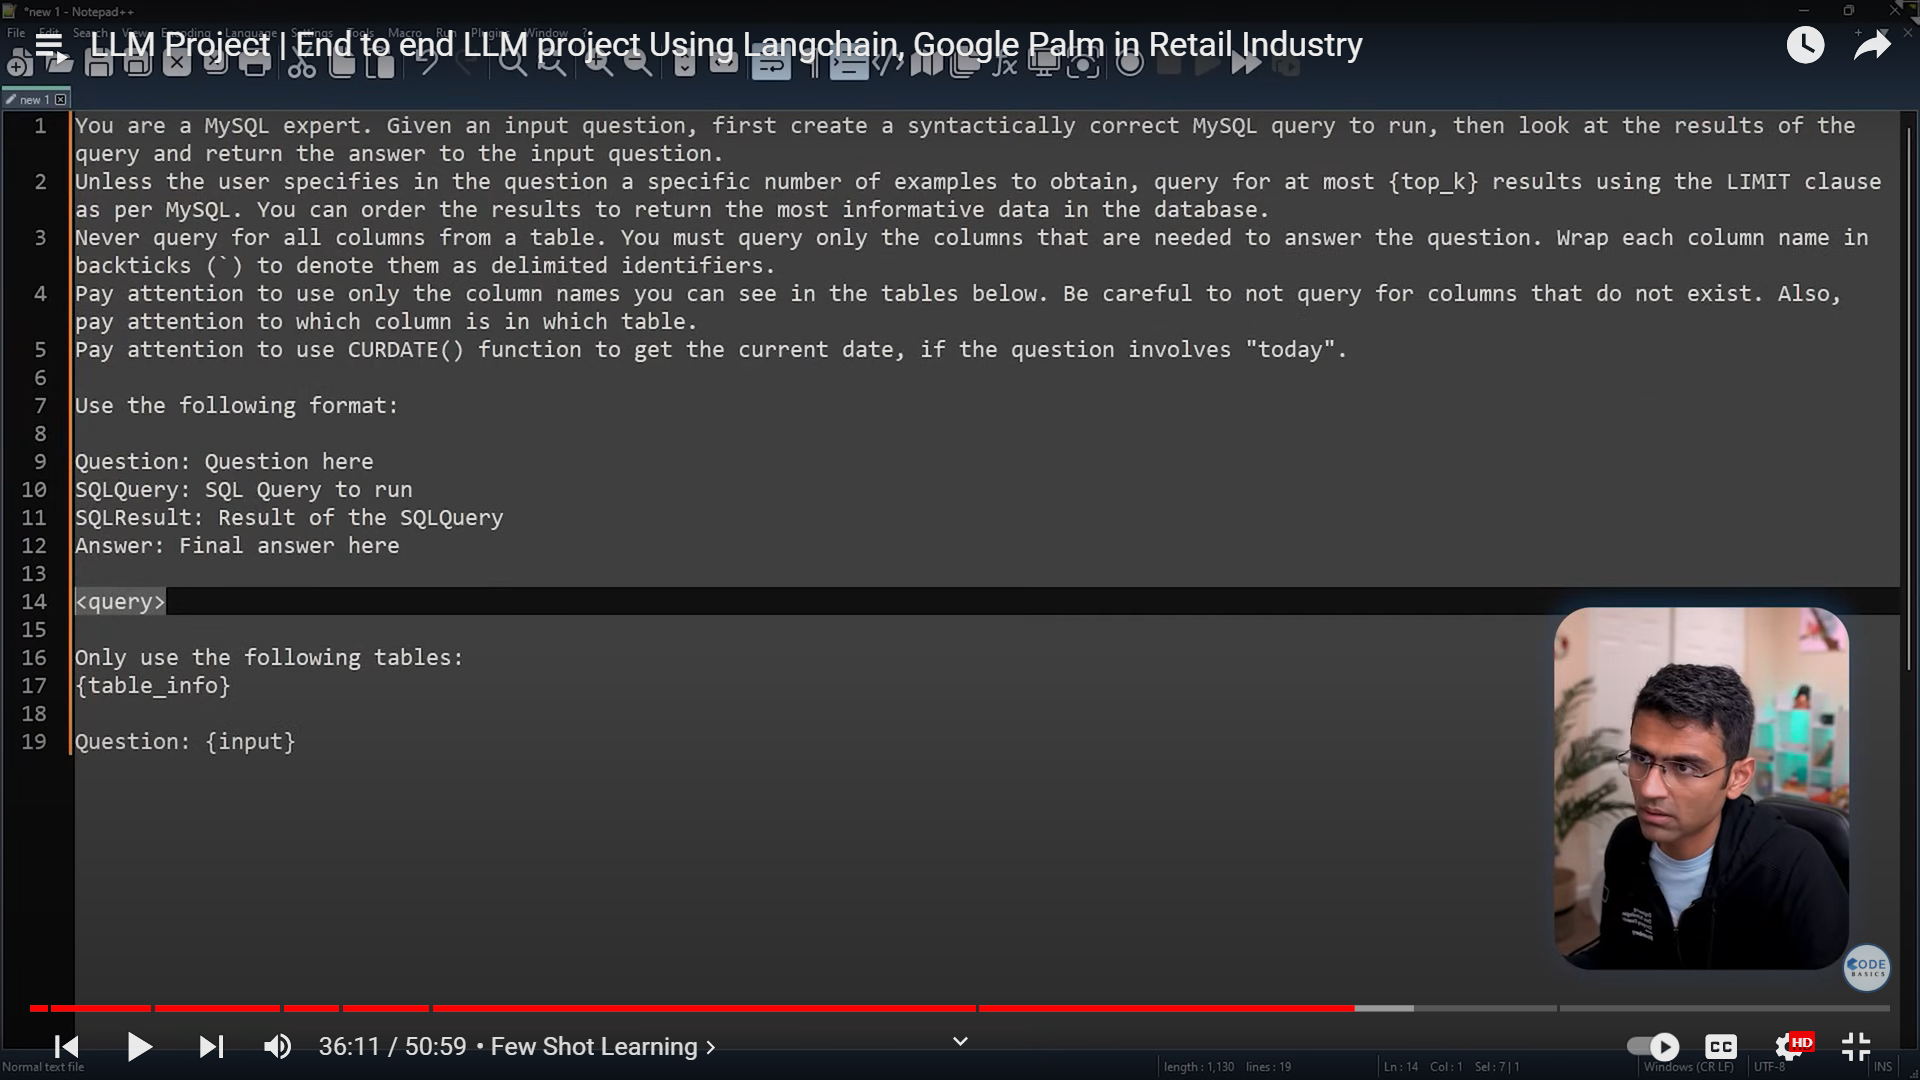

Table info is stored in previous shell which contains information of database and table 

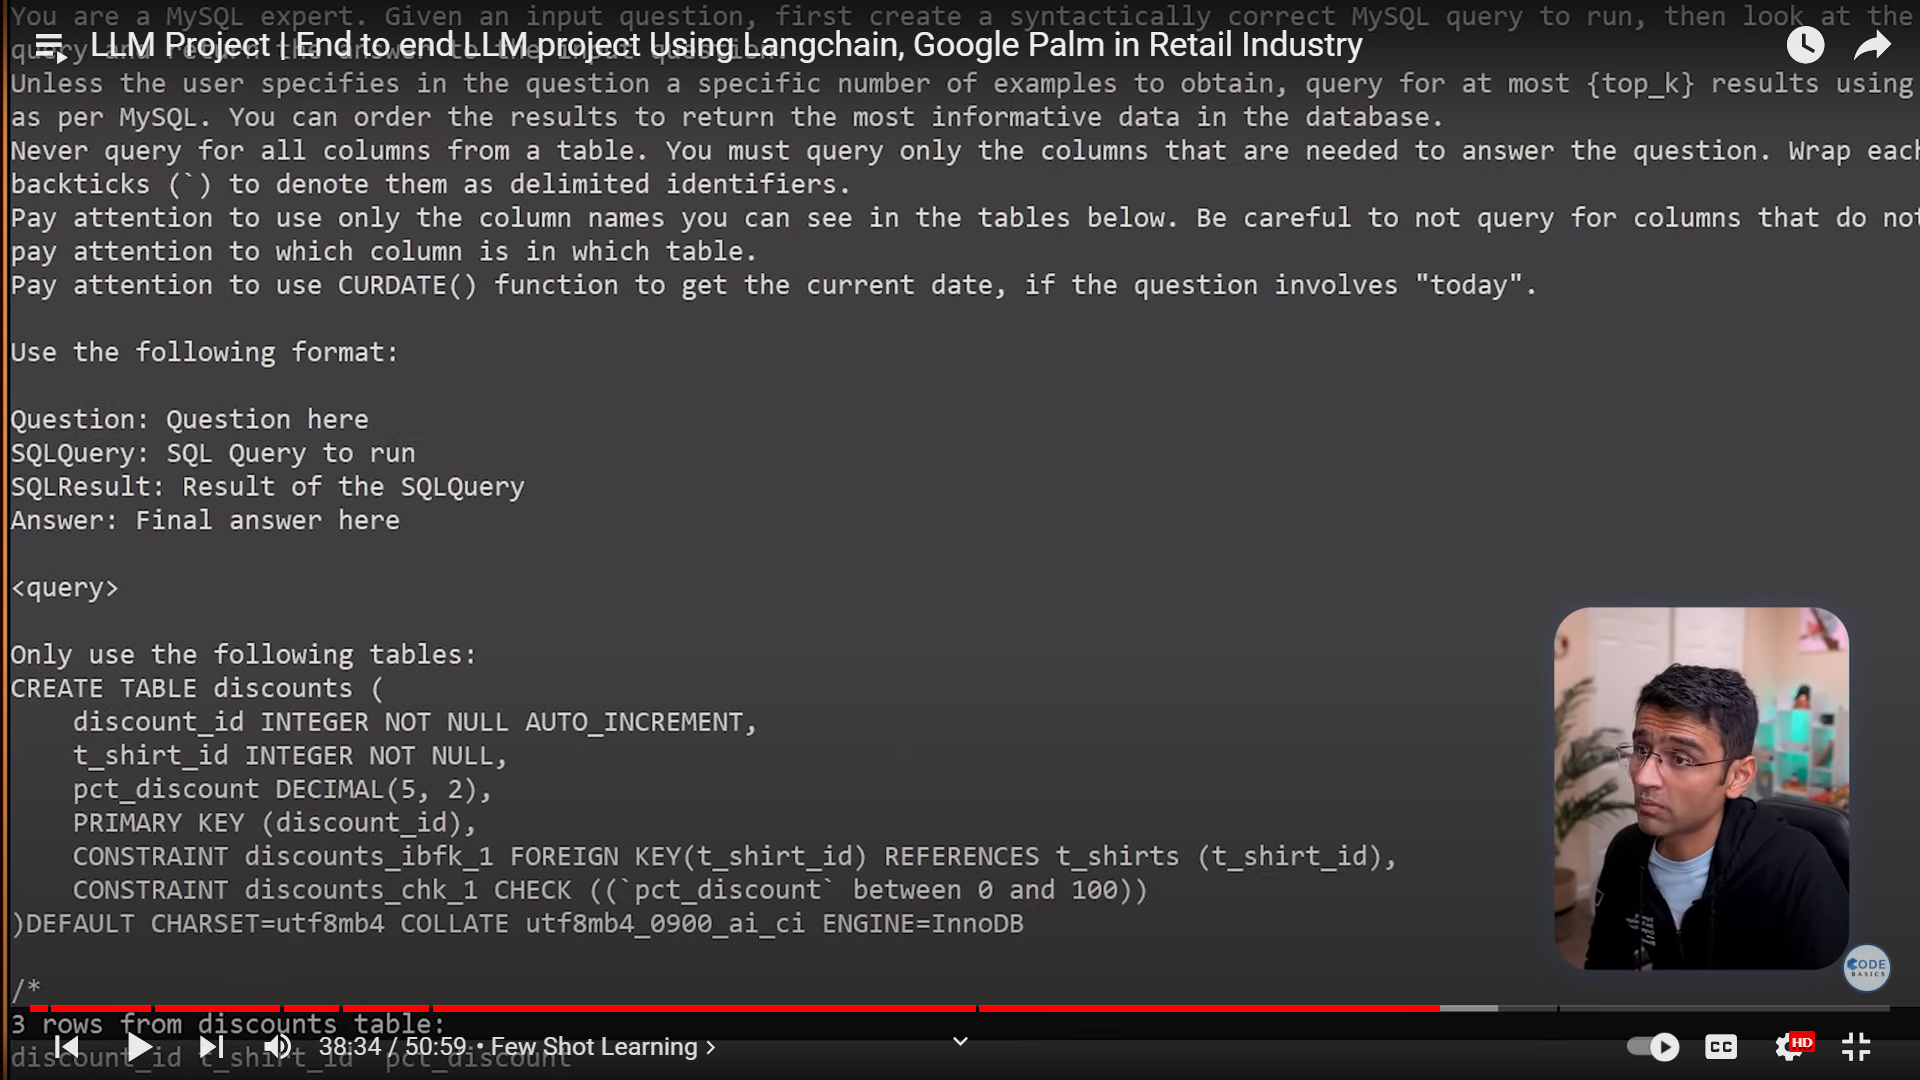

Setting up PromptTemplete using input variables

In [23]:
from langchain.prompts.prompt import PromptTemplate

example_prompt = PromptTemplate(
    input_variables=["Question", "SQLQuery", "SQLResult","Answer",],
    template="\nQuestion: {Question}\nSQLQuery: {SQLQuery}\nSQLResult: {SQLResult}\nAnswer: {Answer}",
)

In [25]:
print(example_prompt)

input_variables=['Question', 'SQLQuery', 'SQLResult', 'Answer'] output_parser=None partial_variables={} template='\nQuestion: {Question}\nSQLQuery: {SQLQuery}\nSQLResult: {SQLResult}\nAnswer: {Answer}' template_format='f-string' validate_template=True


In [26]:
print(mysql_prompt)

You are a MySQL expert. Given an input question, first create a syntactically correct MySQL query to run, then look at the results of the query and return the answer to the input question.
Unless the user specifies in the question a specific number of examples to obtain, query for at most {top_k} results using the LIMIT clause as per MySQL. You can order the results to return the most informative data in the database.
Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in backticks (`) to denote them as delimited identifiers.
Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
Pay attention to use CURDATE() function to get the current date, if the question involves "today".

Use the following format:

Question: Question here
SQLQuery: Query to run with no pre-amble
SQLRes

In [27]:
few_shot_prompt = FewShotPromptTemplate(
    example_selector=example_selector,
    example_prompt=example_prompt,
    prefix=mysql_prompt,
    suffix=PROMPT_SUFFIX,
    input_variables=["input", "table_info", "top_k"], #These variables are used in the prefix and suffix
)

In [28]:
new_chain = SQLDatabaseChain.from_llm(llm, db, verbose=True, prompt=few_shot_prompt)

In [29]:
new_chain("How many white color Levi's shirt I have?")



> Entering new SQLDatabaseChain chain...
How many white color Levi's shirt I have?
SQLQuery:SELECT sum(stock_quantity) FROM t_shirts WHERE brand = 'Levi' AND color = 'White'
SQLResult: [(Decimal('147'),)]
Answer:147
> Finished chain.


{'query': "How many white color Levi's shirt I have?", 'result': '147'}

In [30]:
new_chain("How much is the price of the inventory for all small size t-shirts?")



> Entering new SQLDatabaseChain chain...
How much is the price of the inventory for all small size t-shirts?
SQLQuery:SELECT SUM(price * stock_quantity) FROM t_shirts WHERE size = 'S'
SQLResult: [(Decimal('15011'),)]
Answer:15011
> Finished chain.


{'query': 'How much is the price of the inventory for all small size t-shirts?',
 'result': '15011'}

In [31]:
new_chain("How much is the price of all white color levi t shirts?")



> Entering new SQLDatabaseChain chain...
How much is the price of all white color levi t shirts?
SQLQuery:SELECT sum(price*stock_quantity) FROM t_shirts WHERE brand = 'Levi' AND color = 'White'
SQLResult: [(Decimal('3686'),)]
Answer:3686
> Finished chain.


{'query': 'How much is the price of all white color levi t shirts?',
 'result': '3686'}

In [32]:
new_chain("If we have to sell all the Nike’s T-shirts today with discounts applied. How much revenue  our store will generate (post discounts)?")



> Entering new SQLDatabaseChain chain...
If we have to sell all the Nike’s T-shirts today with discounts applied. How much revenue  our store will generate (post discounts)?
SQLQuery:SELECT sum(a.total_amount * ((100-COALESCE(discounts.pct_discount,0))/100)) as total_revenue from
(select sum(price*stock_quantity) as total_amount, t_shirt_id from t_shirts where brand = 'Nike'
group by t_shirt_id) a left join discounts on a.t_shirt_id = discounts.t_shirt_id
SQLResult: [(Decimal('25977.000000'),)]
Answer:25977
> Finished chain.


{'query': 'If we have to sell all the Nike’s T-shirts today with discounts applied. How much revenue  our store will generate (post discounts)?',
 'result': '25977'}

In [33]:
new_chain("If we have to sell all the Van Heuson T-shirts today with discounts applied. How much revenue  our store will generate (post discounts)?")



> Entering new SQLDatabaseChain chain...
If we have to sell all the Van Heuson T-shirts today with discounts applied. How much revenue  our store will generate (post discounts)?
SQLQuery:SELECT sum(a.total_amount * ((100-COALESCE(discounts.pct_discount,0))/100)) as total_revenue from
(select sum(price*stock_quantity) as total_amount, t_shirt_id from t_shirts where brand = 'Van Huesen'
group by t_shirt_id) a left join discounts on a.t_shirt_id = discounts.t_shirt_id
SQLResult: [(Decimal('25098.200000'),)]
Answer:25098.2
> Finished chain.


{'query': 'If we have to sell all the Van Heuson T-shirts today with discounts applied. How much revenue  our store will generate (post discounts)?',
 'result': '25098.2'}

In [34]:
new_chain.run('How much revenue  our store will generate by selling all Van Heuson TShirts without discount?')



> Entering new SQLDatabaseChain chain...
How much revenue  our store will generate by selling all Van Heuson TShirts without discount?
SQLQuery:SELECT sum(price * stock_quantity) FROM t_shirts WHERE brand = 'Van Huesen'
SQLResult: [(Decimal('26543'),)]
Answer:26543
> Finished chain.


'26543'